# How can the company improve collaboration?

## 📖 Background
You work in the analytics department of a multinational company, and the head of HR wants your help mapping out the company's employee network using message data. 

They plan to use the network map to understand interdepartmental dynamics better and explore how the company shares information. The ultimate goal of this project is to think of ways to improve collaboration throughout the company. 

## 💾 The data

The company has six months of information on inter-employee communication. For privacy reasons, only sender, receiver, and message length information are available [(source)](https://snap.stanford.edu/data/CollegeMsg.html). 

#### Messages has information on the sender, receiver, and time.
- "sender" - represents the employee id of the employee sending the message.
- "receiver" - represents the employee id of the employee receiving the message.
- "timestamp" - the date of the message.
- "message_length" - the length in words of the message.

#### Employees has information on each employee;
- "id" - represents the employee id of the employee.
- "department" - is the department within the company. 
- "location" - is the country where the employee lives.
- "age" - is the age of the employee.

_**Acknowledgments:** Pietro Panzarasa, Tore Opsahl, and Kathleen M. Carley. "Patterns and dynamics of users' behavior and interaction: Network analysis of an online community." Journal of the American Society for Information Science and Technology 60.5 (2009): 911-932._

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings

%matplotlib inline
sb.set_theme(style = 'darkgrid')
warnings.filterwarnings('ignore')

In [2]:
# Loading datasets
messages = pd.read_csv('data/messages.csv', parse_dates = ['timestamp'])
print(messages)

employees = pd.read_csv('data/employees.csv')
print(employees)

      sender  receiver           timestamp  message_length
0         79        48 2021-06-02 05:41:34              88
1         79        63 2021-06-02 05:42:15              72
2         79        58 2021-06-02 05:44:24              86
3         79        70 2021-06-02 05:49:07              26
4         79       109 2021-06-02 19:51:47              73
...      ...       ...                 ...             ...
3507     469      1629 2021-11-24 05:04:57              75
3508    1487      1543 2021-11-26 00:39:43              25
3509     144      1713 2021-11-28 18:30:47              51
3510    1879      1520 2021-11-29 07:27:52              58
3511    1879      1543 2021-11-29 07:37:49              56

[3512 rows x 4 columns]
       id   department location  age
0       3   Operations       US   33
1       6        Sales       UK   50
2       8           IT   Brasil   54
3       9        Admin       UK   32
4      12   Operations   Brasil   51
..    ...          ...      ...  ...
659  183

# Data Assessing
**The data (messages and employees) will be assessed to ascertain if it is clean or not.**

**First, a copy of the original data will be made for this process and further down. This is to have easy access to the original data when the need arises.**

In [3]:
# Copying data
messages_sent = messages.copy()
employees_data = employees.copy()

#### Checking for missing values

In [4]:
print(messages_sent.info())
print(employees_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sender          3512 non-null   int64         
 1   receiver        3512 non-null   int64         
 2   timestamp       3512 non-null   datetime64[ns]
 3   message_length  3512 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 109.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          664 non-null    int64 
 1   department  664 non-null    object
 2   location    664 non-null    object
 3   age         664 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 20.9+ KB
None


**The messages_sent and employees_data have no missing values as observed from the results obtained above. The columns also have appropriate data types assigned to them. The timestamp has datetime64[ns] as its data type, sender and receiver both integers, and same goes with other features in the data set.**

**One issue arises, though trivial but important, sender and receiver in the messages_sent data both indicate the sender and receiver of the message(s) respectively, but are actually the id of both, thus the columns will be renamed to sender_id and receiver_id respectively. This is to properly communicate what the feature (column) actually contains.**

In [5]:
# Renaming columns
messages_sent.rename(columns = {'sender':'sender_id', 'receiver':'receiver_id'}, inplace = True)
messages_sent.head(2)

,sender_id,receiver_id,timestamp,message_length
0,79,48,2021-06-02 05:41:34,88
1,79,63,2021-06-02 05:42:15,72


#### Checking for duplicates

In [6]:
messages_sent.duplicated().sum()

3

**Exploring further on duplicated values**

In [7]:
# Create a new column `duplicate_values` to check and print duplicates
duplicate_values = messages_sent.duplicated(keep = False)
messages_sent[duplicate_values]

,sender_id,receiver_id,timestamp,message_length
3333,1807,32,2021-10-13 22:25:17,50
3365,1657,1675,2021-11-02 07:42:25,52
3377,1881,1676,2021-11-17 06:45:28,27
3446,1807,32,2021-10-13 22:25:17,50
3478,1657,1675,2021-11-02 07:42:25,52
3490,1881,1676,2021-11-17 06:45:28,27


**From all indications, the values are duplicated and thus will be dropped. This decision was taken because a particular sender (sender_id) cannot send the same exact message with the same message length, at the same date and same exact timestamp, to the same receiver (receiver_id). In real time, there must have been a difference in the time in seconds.**

In [8]:
# Drop duplicates
messages_sent = messages_sent.drop_duplicates()

# check
messages_sent.duplicated().sum()

0

# Merging Datasets
**The `messages_sent` and `employee_data` will be merged using the `sender_id`, `receiver_id` and `id`. In order to achieve a successful merge, the dataframe's must have a common key, in this case, sender_id, receiver_id and id.**

**One issue arises: the key columns do not have same name. In order to resolve this, feature engineering will be used to copy the sender_id and receiver_id to a new column named `id` in the message_sent dataframe. This column will be dropped once the merge is completed since it is a copy of an already existing feature.**

**The merge will use a `left join` as this will filter all the messages sent by each employee using the sender_id, including their details and receiver_id too.**

>NOTE: The data in the sender_id, receiver_id and the feature engineered id column is the same, only a change of name to enable merging the two data frames. The id column will be dropped after.

In [9]:
# Feature engineering: new column named 'id' in messages_sent for sender_id
messages_sent['id'] = messages_sent['sender_id']

# Merging data frames using 'left join' on 'id'
df_x = pd.merge(messages_sent, employees_data, how = 'left', on = 'id')

# Dropping feature engineered column: id
df_x.drop('id', axis = 1, inplace = True)

# Feature engineering: new column named 'id' in messages_sent for receiver_id
df_x['id'] = df_x['receiver_id']

# Merging data frames using 'left join' on 'id'
df = pd.merge(df_x, employees_data, how = 'left', on = 'id')

# Dropping feature engineered column: id
df.drop('id', axis = 1, inplace = True)

# Check for duplicated values
print('There are {} duplicated values'.format(df_x.duplicated().sum()))

# First two rows of merged data frame
df.head(2)

There are 0 duplicated values


,sender_id,receiver_id,timestamp,message_length,department_x,location_x,age_x,department_y,location_y,age_y
0,79,48,2021-06-02 05:41:34,88,Sales,France,33,IT,France,34
1,79,63,2021-06-02 05:42:15,72,Sales,France,33,Sales,France,38


**The following modifications will be made to make the dataframe suitable for our analysis:**
- department_x and department_y will be renamed to sender_department and receiver_department respectively
- location_x and location_y will be renamed to sender_location and receiver_location respectively
- age_x and age_y will be renamed to sender_age and receiver_age respectively
- A new column 'month' will be created from the timestamp so the trend of messages sent and received by each department can be visualized

In [10]:
# Renaming dataframe columns:
df.rename(columns = {'department_x':'sender_department', 'department_y':'receiver_department',
                     'location_x':'sender_location', 'location_y':'receiver_location',
                     'age_x':'sender_age', 'age_y':'receiver_age'}, inplace = True)

# Extract the month form the timestamp
df['month'] = df['timestamp'].dt.month

# First 10 rows of the new data frame
df.head(10)

,sender_id,receiver_id,timestamp,message_length,sender_department,sender_location,sender_age,receiver_department,receiver_location,receiver_age,month
0,79,48,2021-06-02 05:41:34,88,Sales,France,33,IT,France,34,6
1,79,63,2021-06-02 05:42:15,72,Sales,France,33,Sales,France,38,6
2,79,58,2021-06-02 05:44:24,86,Sales,France,33,Sales,Germany,40,6
3,79,70,2021-06-02 05:49:07,26,Sales,France,33,Operations,France,47,6
4,79,109,2021-06-02 19:51:47,73,Sales,France,33,Marketing,Brasil,32,6
5,79,58,2021-06-03 01:12:11,37,Sales,France,33,Sales,Germany,40,6
6,144,99,2021-06-03 09:54:41,33,Sales,US,50,Engineering,UK,34,6
7,144,105,2021-06-03 09:57:02,80,Sales,US,50,IT,US,52,6
8,144,121,2021-06-03 09:59:16,13,Sales,US,50,Admin,France,43,6
9,177,32,2021-06-04 07:50:33,32,Operations,Brasil,39,Sales,UK,54,6


**The final dataframe obtained contains detailed information needed for our analysis. From the dataframe, details about the sender and receiver (id, department, location, and age) can easily be obtained.**

**The final dataframe will be saved as a master data. This is to have easy access to the data used for the analysis and avoid repeating the process before hand.**

In [33]:
# Saving final data set
df.to_csv('data/master_data_set.csv', index = False)

# Exploratory Data Analysis

**In this section, we will make use of the already prepared `master_data_set` as it contains all information needed to derive insights and make decisions.**

In [12]:
# Loading master data set
df = pd.read_csv('data/master_data_set', parse_dates = ['timestamp'])

In [13]:
# Creating a count plot function for visualization and to avoid code repetition
def count_plot(dataframe, feature, title, x_label, y_label, order):
    """
    A function that plots the count of a feature in a given dataframe using seaborn countplot.
    
    Args:
        dataframe: Dataframe from which data will be plotted.
        feature: Column to be plotted
        title: Histogram title inputed as string with quoatation marks.
        x_label: x_axis label inputed as string with quoatation marks.
        y_label: y_axis label inputed as string with quoatation marks.
        order: Order in which the data will be plotted. If the data is to be plotted in no order, input 'None'.
    """
    ax = sb.countplot(data = dataframe, x = feature, color = sb.color_palette()[0], order = order)
    plt.title(title, fontsize = 15)
    plt.xlabel(x_label, fontsize = 15)
    plt.ylabel(y_label, fontsize = 15)
    plt.xticks(size = 10)
    plt.yticks(size = 10);
    plt.show()

## 1. Which departments are the most/least active?

**The most/least active department can come from both the receiving and the sending departments. Considering the origin of the message (sending department), there is a department that is most active, and also a department that is least active. This is same when considering the destination (receiving department) of the messages.**

In [14]:
# Get count of number of times each department sent a message
sending_departments = df.groupby(['sender_department'])['sender_id', 'timestamp'].count().sort_values('sender_id', ascending = False)
sending_departments['message_count'] = sending_departments['sender_id']
sending_departments[['message_count']]

,message_count
sender_department,
Sales,1549
Operations,1013
Admin,856
IT,49
Engineering,26
Marketing,16


**With reference to the sending department, the _most active_ is the _Sales Department_ with a total message count of _1549_ for the period of six months. This might be attributed to the fact that they engage in sales of the company product(s) and constantly need updates on different products from different departments. The _least active_ department is the _Marketing Department_ with a total message count of _16_ for the six months period under study.**

In [15]:
# Get count of number of times each department received a message
receiving_departments = df.groupby(['receiver_department'])['receiver_id', 'timestamp'].count().sort_values('receiver_id', ascending = False)
receiving_departments['message_count'] = receiving_departments['receiver_id']
receiving_departments[['message_count']]

,message_count
receiver_department,
Sales,1227
Operations,845
Admin,797
Engineering,251
IT,249
Marketing,140


**At the receiving end, the _Sales Department_ is still the most active with a total message count of _1227_. The _Marketing Department_ is still the _least active_ in this aspect with a message count of _140_, though with a huge increase compared with the sending department.**

**Visualizing the above results:**

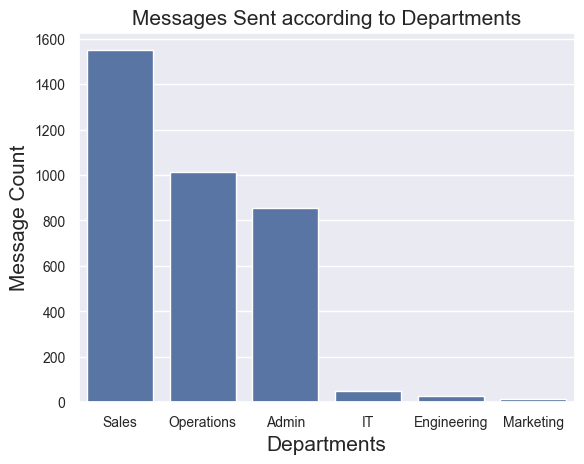

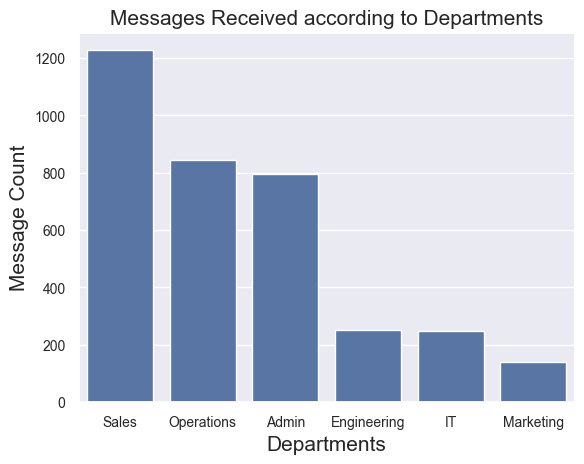

In [16]:
# Sender department
order = df['sender_department'].value_counts().index
count_plot(df, 'sender_department', 'Messages Sent according to Departments', 'Departments', 'Message Count', order)

# Receiver department
order = df['receiver_department'].value_counts().index
count_plot(df, 'receiver_department', 'Messages Received according to Departments', 'Departments', 'Message Count', order)

**From the visualization, one can easily infer how all the departments performed from the sending and receiving perspectives.**

# 2. Which employee(s) has the most connections?

**This is a count a different receiver_id's and receiver_department's a particular sender_id have sent a message.**

#### **i. From the senders end, how many unique receiver_id has a particular sender_id (employee) sent a message to?**

In [31]:
# Connections with reference to receiver_id
most_connection_by_sender = df.groupby(['sender_id'])['receiver_id', 'receiver_department'].nunique().sort_values('receiver_id', ascending = False).head(2)
most_connection_by_sender.rename(columns = {'receiver_id':'receiver_id_count', 'receiver_department':'receiver_department_count'}, inplace = True)
most_connection_by_sender[['receiver_id_count', 'receiver_department_count']]

,receiver_id_count,receiver_department_count
sender_id,,
598,77,6
144,75,6


**The employee with id _598_ has the most connections with _77_ unique receiver_id count. This employee (598) have sent at least a message to 77 other employees in the six departments, theirs included, thus having more connections from the sending end.**

In [18]:
# Connection with reference to receiver_department
most_connection_by_department = df.groupby(['sender_id'])['receiver_id', 'receiver_department'].nunique().sort_values('receiver_department', ascending = False).head(20)
most_connection_by_department.rename(columns = {'receiver_department':'receiver_department_count'}, inplace = True)
most_connection_by_department[['receiver_department_count']]

,receiver_department_count
sender_id,
79,6
317,6
128,6
605,6
598,6
586,6
1021,6
509,6
483,6


**With reference to different departments which an employee have sent a message to, there are 20 employee's in this category with _6_ unique departments each. These employee's have sent a message to another employee in all the six departments, theirs included. The employee with id _598_ also appears in this category.**

#### **ii. From the receivers end, how many unique sender_id has a particular receiver_id (employee) received a message from?**

In [32]:
# Connections with reference to sender_id
most_connection_by_sender = df.groupby(['receiver_id'])['sender_id', 'sender_department'].nunique().sort_values('sender_id', ascending = False).head(3)
most_connection_by_sender.rename(columns = {'sender_id':'sender_id_count', 'sender_department':'sender_department_count'}, inplace = True)
most_connection_by_sender[['sender_id_count', 'sender_department_count']]

,sender_id_count,sender_department_count
receiver_id,,
194,13,4
32,11,3
249,9,3


**The employee with id _194_ has the most connections with _13_ unique sender_id count. This employee (194) have received at least a message to 13 other employees from different departments, thus having more connections when from the receiving end.**

In [20]:
# Connection with reference to sender_department
most_connection_by_department = df.groupby(['receiver_id'])['sender_id', 'sender_department'].nunique().sort_values('sender_department', ascending = False).head(6)
most_connection_by_department.rename(columns = {'sender_department':'sender_department_count'}, inplace = True)
most_connection_by_department[['sender_department_count']]

,sender_department_count
receiver_id,
704,4
194,4
1281,4
400,4
617,4
368,4


**With reference to different departments which an employee have received a message from, there are 6 employee's in this category with _4_ unique departments each. These employee's have received at least a message to another employee from four (4) different departments, theirs included. The employee with id _194_ also appears in this category.**

**Considering counts only, the employee with id _598_ has the most connections with a count of _77_, while taking into account the sending and receiving id, the employee with id _194_ has the most connections from the receiving end.**

# 3. Identify the most influential departments and employees.
- **Most influential department(s):** The department(s) that has the most connection when sending/receiving messages from other departments or employees.

In [29]:
# Most influential department from considering message orrigination
most_influential_department = df.groupby(['sender_department'])['receiver_id', 'receiver_department'].nunique().sort_values('receiver_id', ascending = False)
most_influential_department.rename(columns = {'receiver_id':'receiver_id_count', 'receiver_department':'receiver_department_count'}, inplace = True)
most_influential_department

,receiver_id_count,receiver_department_count
sender_department,,
Sales,364,6
Operations,287,6
Admin,179,6
IT,31,6
Engineering,22,5
Marketing,7,4


In [30]:
# Most influential department from considering message destination
most_influential_department = df.groupby(['receiver_department'])['sender_id', 'sender_department'].nunique().sort_values('sender_id', ascending = False)
most_influential_department.rename(columns = {'sender_id':'sender_id_count', 'sender_department':'sender_department_count'}, inplace = True)
most_influential_department

,sender_id_count,sender_department_count
receiver_department,,
Sales,62,6
Admin,59,6
Operations,59,6
Engineering,51,6
IT,44,5
Marketing,34,4


- **Most influential employee(s):** The employee(s) that has the most connection when sending/receiving messages from other departments or employees.

## 💪 Competition challenge

Create a report that covers the following:  
  1. Which departments are the most/least active?
  2. Which employee has the most connections? 
  3. Identify the most influential departments and employees.
  4. Using the network analysis, in which departments would you recommend the HR team focus to boost collaboration?
  
  - Visualization for messages sent by each department per month
  - Visualization for messages received by each department per month

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul> |
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul> |
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

## ✅ Checklist before publishing into the competition
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights. 
- Try to include an **executive summary** of your recommendations at the beginning.
- Check that all the cells run without error

## ⌛️ Time is ticking. Good luck!